In [12]:
## read data function 
readData <- function(path.name, file.name, column.types, missing.types) {
  read.csv( paste(path.name, file.name, sep=""), 
            colClasses=column.types,
            na.strings=missing.types )
}

Titanic.path <- "~/notebooks/kaggle-titanic/"
train.data.file <- "train.csv"
test.data.file <- "test.csv"
missing.types <- c("NA", "")
train.column.types <- c('integer',   # PassengerId
                        'factor',    # Survived 
                        'factor',    # Pclass
                        'character', # Name
                        'factor',    # Sex
                        'numeric',   # Age
                        'integer',   # SibSp
                        'integer',   # Parch
                        'character', # Ticket
                        'numeric',   # Fare
                        'character', # Cabin
                        'factor'     # Embarked
)
test.column.types <- train.column.types[-2]     # # no Survived column in test.csv

## train
train.raw <- readData(Titanic.path, train.data.file, 
                      train.column.types, missing.types)
df.train <- train.raw

## test
test.raw <- readData(Titanic.path, test.data.file, 
                     test.column.types, missing.types)
df.infer <- test.raw   

In [13]:
summary(df.train$Sex)
summary(df.train$Survived)
summary(df.train$Age)
summary(df.train$Fare)

female   male 
   314    577

0   1 
549 342

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0      20      28      30      38      80     177 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       8      14      32      31     512 

In [18]:
# alot of missing age data.
# lets try to make up for this by searching for the names by miss, ms, master, mister etc.
## function for extracting honorific (i.e. title) from the Name feature
getTitle <- function(data) {
  title.dot.start <- regexpr("\\,[A-Z ]{1,20}\\.", data$Name, TRUE)
  title.comma.end <- title.dot.start+attr(title.dot.start, "match.length")-1
  data$Title <- substr(data$Name, title.dot.start+2, title.comma.end-1)
  return (data$Title)
}


df.train$Title <- getTitle(df.train)
unique(df.train$Title)

[1] "Mr"           "Mrs"          "Miss"         "Master"       "Don"         
 [6] "Rev"          "Dr"           "Mme"          "Ms"           "Major"       
[11] "Lady"         "Sir"          "Mlle"         "Col"          "Capt"        
[16] "the Countess" "Jonkheer"

In [19]:
options(digits=2)
require(Hmisc)
bystats(df.train$Age, df.train$Title, fun=function(x)c(Mean=mean(x),Median=median(x)))


 c(3, 43, 3, 85, 43, 85, 3, 3) of df.train$Age by df.train$Title 

               N Missing Mean Median
Capt           1       0 70.0   70.0
Col            2       0 58.0   58.0
Don            1       0 40.0   40.0
Dr             6       1 42.0   46.5
Jonkheer       1       0 38.0   38.0
Lady           1       0 48.0   48.0
Major          2       0 48.5   48.5
Master        36       4  4.6    3.5
Miss         146      36 21.8   21.0
Mlle           2       0 24.0   24.0
Mme            1       0 24.0   24.0
Mr           398     119 32.4   30.0
Mrs          108      17 35.9   35.0
Ms             1       0 28.0   28.0
Rev            6       0 43.2   46.5
Sir            1       0 49.0   49.0
the Countess   1       0 33.0   33.0
ALL          714     177 29.7   28.0

In [20]:
titles.na.train <- c("Dr", "Master", "Mrs", "Miss", "Mr")

imputeMedian <- function(impute.var, filter.var, var.levels) {
  for (v in var.levels) {
    impute.var[ which( filter.var == v)] <- impute(impute.var[ 
      which( filter.var == v)])
  }
  return (impute.var)
}

df.train$Age[which(df.train$Title=="Dr")]

[1] 44 54 23 32 50 NA 49

In [21]:
df.train$Age <- imputeMedian(df.train$Age, df.train$Title, titles.na.train)
df.train$Age[which(df.train$Title=="Dr")]
summary(df.train$Age)

[1] 44 54 23 32 50 46 49

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0      21      30      29      35      80 

In [22]:
## replace missing values for embarking with the most common value
df.train$Embarked[which(is.na(df.train$Embarked))] <- 'S'

In [23]:
summary(df.train$Fare)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
      0       8      14      32      31     512 

In [24]:
subset(df.train, Fare < 7)[order(subset(df.train, Fare < 7)$Fare, 
                                 subset(df.train, Fare < 7)$Pclass), c("Age", "Title", "Pclass", "Fare")]

,Age,Title,Pclass,Fare
264,40,Mr,1,0
634,30,Mr,1,0
807,39,Mr,1,0
816,30,Mr,1,0
823,38,Jonkheer,1,0
278,30,Mr,2,0
414,30,Mr,2,0
467,30,Mr,2,0
482,30,Mr,2,0
675,30,Mr,2,0


In [25]:
df.train$Fare[ which( df.train$Fare == 0 )] <- NA
df.train$Fare <- imputeMedian(df.train$Fare, df.train$Pclass, 
                              as.numeric(levels(df.train$Pclass)))

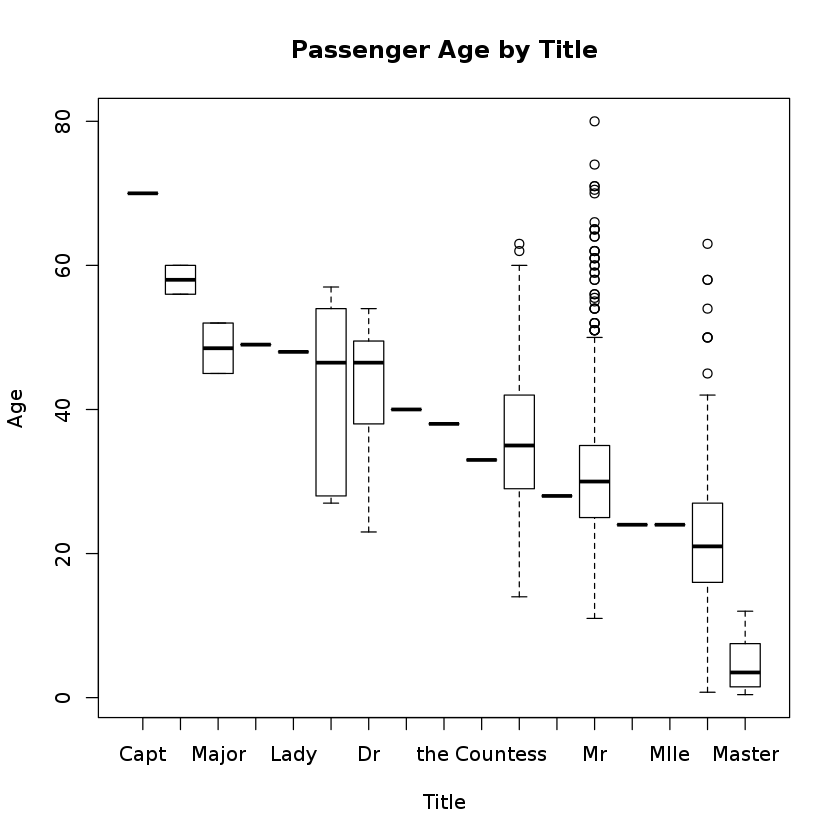

In [26]:
df.train$Title <- factor(df.train$Title,
                         c("Capt","Col","Major","Sir","Lady","Rev",
                         "Dr","Don","Jonkheer","the Countess","Mrs",
                         "Ms","Mr","Mme","Mlle","Miss","Master"))
boxplot(df.train$Age ~ df.train$Title, 
        main="Passenger Age by Title", xlab="Title", ylab="Age")

In [27]:
## function for assigning a new title value to old title(s) 
changeTitles <- function(data, old.titles, new.title) {
  for (honorific in old.titles) {
    data$Title[ which( data$Title == honorific)] <- new.title
  }
  return (data$Title)
}

## Title consolidation
df.train$Title <- changeTitles(df.train, 
                               c("Capt", "Col", "Don", "Dr", 
                               "Jonkheer", "Lady", "Major", 
                               "Rev", "Sir"),
                               "Noble")
df.train$Title <- changeTitles(df.train, c("the Countess", "Ms"), 
                               "Mrs")
df.train$Title <- changeTitles(df.train, c("Mlle", "Mme"), "Miss")
df.train$Title <- as.factor(df.train$Title)

Warning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA generatedWarning message:
In `[<-.factor`(`*tmp*`, which(data$Title == honorific), value = "Noble"): invalid factor level, NA g

In [39]:
require(plyr)     # for the revalue function 
require(stringr)  # for the str_sub function

## test a character as an EVEN single digit
isEven <- function(x) x %in% c("0","2","4","6","8") 
## test a character as an ODD single digit
isOdd <- function(x) x %in% c("1","3","5","7","9") 

## function to add features to training or test data frames
featureEngrg <- function(data) {
  ## Using Fate ILO Survived because term is shorter and just sounds good
  data$Fate <- data$Survived
  ## Revaluing Fate factor to ease assessment of confusion matrices later
  data$Fate <- revalue(data$Fate, c("1" = "Survived", "0" = "Perished"))
  ## Boat.dibs attempts to capture the "women and children first"
  ## policy in one feature.  Assuming all females plus males under 15
  ## got "dibs' on access to a lifeboat
  data$Boat.dibs <- "No"
  data$Boat.dibs[which(data$Sex == "female" | data$Age < 15)] <- "Yes"
  data$Boat.dibs <- as.factor(data$Boat.dibs)
  ## Family consolidates siblings and spouses (SibSp) plus
  ## parents and children (Parch) into one feature
  data$Family <- data$SibSp + data$Parch
  ## Fare.pp attempts to adjust group purchases by size of family
  data$Fare.pp <- data$Fare/(data$Family + 1)
  ## Giving the traveling class feature a new look
  data$Class <- data$Pclass
  data$Class <- revalue(data$Class, 
                        c("1"="First", "2"="Second", "3"="Third"))
  ## First character in Cabin number represents the Deck 
  data$Deck <- substring(data$Cabin, 1, 1)
  data$Deck[ which( is.na(data$Deck ))] <- "UNK"
  data$Deck <- as.factor(data$Deck)
  ## Odd-numbered cabins were reportedly on the port side of the ship
  ## Even-numbered cabins assigned Side="starboard"
  data$cabin.last.digit <- str_sub(data$Cabin, -1)
  data$Side <- "UNK"
  data$Side[which(isEven(data$cabin.last.digit))] <- "port"
  data$Side[which(isOdd(data$cabin.last.digit))] <- "starboard"
  data$Side <- as.factor(data$Side)
  data$cabin.last.digit <- NULL
  return (data)
}

## add remaining features to training data frame
df.train <- featureEngrg(df.train)

In [42]:
Titanic.logit.1 <- glm(Fate ~ Sex + Class + Age + Family + Embarked + Fare, 
                       data = train.batch, family=binomial("logit")

ERROR: Error in parse(text = x, srcfile = src): <text>:3:0: unexpected end of input
1: Titanic.logit.1 <- glm(Fate ~ Sex + Class + Age + Family + Embarked + Fare, 
2:                        data = train.batch, family=binomial("logit")
  ^
